# Homework 7 *\[submission template\]*

In [ ]:
%pip install matplotlib --upgrade
%pip install celluloid
%matplotlib inline
%pip install scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 21.8 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.8.0
    Uninstalling matplotlib-3.8.0:
      Successfully uninstalled matplotlib-3.8.0


In [ ]:
from dataclasses import dataclass
import enum

import numpy as np
import matplotlib.pyplot as plt

# your additional imports here
import copy
from collections import defaultdict

In [ ]:
RNG = np.random.default_rng()

# your additional global initialization here

## §1. Implementing generic Markov chain simulations

#### CODE: `Model` interface

In [ ]:
class Model:

    def transition_rate(self, state):
        """Total transition rate out of the given state"""
        raise NotImplementedError

    def sample_next(self, state):
        """Generates a random state to come after the given state"""
        raise NotImplementedError

#### CODE: simulating *discrete-time* Markov chains

In [ ]:
def run_dtmc(model: Model, state_init, n_steps=256):
    path = [state_init]
    for i in range(n_steps):
        path.append(model.sample_next(path[-1]))
    # Return a list of (time, state) pairs
    # This simulation is discrete-time, so time is an integer
    return list(enumerate(path))

#### CODE: `QueueModel` example

In [ ]:
@dataclass
class QueueModel(Model):
    """Model of a queue

    The state is the number of customers currently in the queue.

    Parameters
    ----------
    rate_arrival: float
        Rate at which customers arrive at the queue.

    rate_service: float
        Rate at which customers leave the queue when it is nonempty.
    """

    rate_arrival: float
    rate_service: float

    def transition_rate(self, state: int):
        if state == 0:
            return self.rate_arrival
        else:
            return self.rate_arrival + self.rate_service

    def sample_next(self, state: int):
        if RNG.random() < self.rate_arrival / self.transition_rate(state):
            return state + 1
        else:
            return state - 1

In [ ]:
def visualize_queue_path(path):
    plt.plot(*np.asarray(path).T)

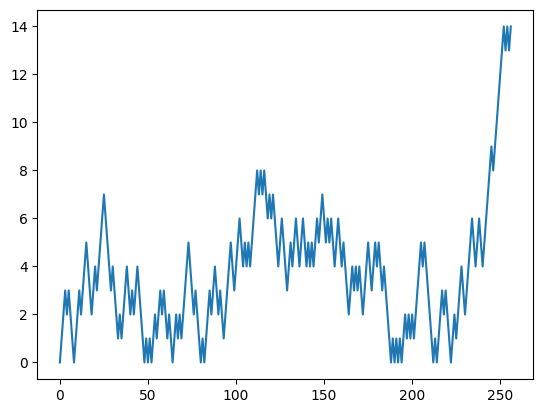

In [ ]:
visualize_queue_path(run_dtmc(QueueModel(5, 6), 0))

#### ANSWER

In [ ]:
def run_ctmc(model: Model, state_init, n_steps=256):
    """
    Continuous-time version of `run_dtmc`.

    Parameters
    ----------
    model: Model
        The Markov model with methods `transition_rate` and `sample_next`.
    state_init: int
        The initial state of the Markov chain.
    n_steps: int
        Number of steps to simulate.

    Returns
    -------
    path: list of (time, state) pairs
        A list of tuples where the first element is the time and the second is the state.
    """
    path = [(0.0, state_init)]
    current_state = state_init
    current_time = 0.0

    for _ in range(n_steps):
        # Compute the total transition rate for the current state
        rate = model.transition_rate(current_state)
        if rate <= 0:
            raise ValueError("Transition rate must be positive.")

        # Sample time to the next event
        time_to_next = RNG.exponential(1 / rate)
        current_time += time_to_next

        # Determine the next state
        next_state = model.sample_next(current_state)

        # Append the new (time, state) pair to the path
        path.append((current_time, next_state))

        # Update current state
        current_state = next_state

    return path

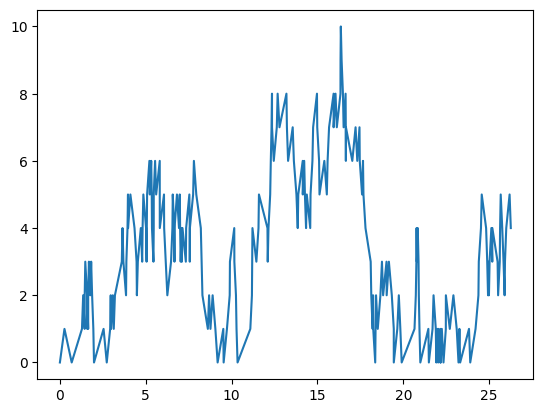

In [ ]:
# An initial test
visualize_queue_path(run_ctmc(QueueModel(5, 6), 0))

## §2. Implementing initial model for the project

#### ANSWER

In [ ]:
#Fixed Code

# You could change these to use tuples instead of
# having separate fields for each level...

@dataclass(frozen=True)
class SimpleWorkplaceState:
    """State of a Company

    The state is the number of employees in each level of the company.

    Parameters
    ----------
    n: list[list[int]]
        number of female and male employees at each level.
    """
    n    : list[list[int]]

@dataclass(frozen=True)
class WorkplaceParams:
    """Parameters of a Company model

    Parameters
    ---------
      levels: list[int]
          number of levels in the company.

      identity: list[int]
          identities of an employee.
          identity[0] is the female and identity[1] is male.

      departure_rate: list[list[float]]
          rate of departure for each level for each identity.

      hiring_promotion_rate: list[list[float]]
          rate for hiring level 0 and promoting an employee at each level l > 0 for each identity.
      has_seniority: if true, add seniority in complex model
      has_homophily: if true, add homophily in complex model
      (can be both or just one of them)
      female related is at index 0, male is at index 1
    """
    levels            : list[int]
    identity          : list[int]
    departure_rate    : list[list[float]]
    hiring_promotion_rate  : list[list[float]]
    has_seniority: bool
    has_homophily: bool

@dataclass(frozen=True)
class SimpleWorkplaceModel:
    """Model of a Company

    The state is the number of employees in each level of the company.

    Parameters
    ----------
    """
    params: WorkplaceParams

    def transition_rate(self, state: SimpleWorkplaceState):
        """
        The following rates are added together to get the total transition rate:
            rates of departing employees of each identity for each level
        """
        total_rate = 0
        for level in range(len(self.params.levels)):
          for i in self.params.identity:
            total_rate += self.params.departure_rate[level][i] * state.n[level][i]
        return total_rate

    def sample_next(self, state: SimpleWorkplaceState):
        next_state_n = copy.deepcopy(state.n)
        rand_num = RNG.random() * self.transition_rate(state)
        #Since it is exponential distribution, there won't be two departure happen at the same time
        left_level = -1
        cumulative_rate = 0
        for level in range(len(self.params.levels)):
          for i in self.params.identity:
            if left_level != -1:
              continue
            cumulative_rate += self.params.departure_rate[level][i] * state.n[level][i]
            if rand_num < cumulative_rate:
              next_state_n[level][i] -= 1
              left_level = level


        # we need to fill vacancies from top level
        for i in range(left_level, -1, -1):
          if i == 0: # new hire
            if RNG.random() < self.params.hiring_promotion_rate[i][0] / sum(self.params.hiring_promotion_rate[i]):
              next_state_n[0][0] += 1 # hire female
            else:
              next_state_n[0][1] += 1 # hire male
          else:  # Promotion from lower level

            female_promotion_weights = self.params.hiring_promotion_rate[i][0] * state.n[i-1][0]
            male_promotion_weights = self.params.hiring_promotion_rate[i][1] * state.n[i-1][1]

            prob_female_promotion = female_promotion_weights / (female_promotion_weights + male_promotion_weights)
            if RNG.random() < prob_female_promotion:
                next_state_n[i - 1][0] -= 1
                next_state_n[i][0] += 1  # Promote female
            else:
                next_state_n[i - 1][1] -= 1
                next_state_n[i][1] += 1  # Promote male

        return SimpleWorkplaceState(next_state_n)

Note: we may need to calculate vacancies from the top-down to account for unfilled gaps in the lower levels after promotions

In [ ]:
import networkx as nx

def visualize_workplace_state(time, state: SimpleWorkplaceState):
  """
  Visualizes a simple workplace state with levels and a count of each employee
  separated by gender identity
  """
  G = nx.Graph()
  nodes = []
  node_values = []
  edges = {}

  # collect nodes and edges from workplace state
  for level in range(len(state.n)-1,-1,-1):
    attribute = {'level': level}
    node_m = (f"M:{state.n[level][1]}")
    node_f = (f"F:{state.n[level][0]}")
    node_values.append(state.n[level][1])
    node_values.append(state.n[level][0])
    nodes.append((node_m, attribute))
    nodes.append((node_f, attribute))
    edges[(node_m, node_f)] = f'Level {level}'

  G.add_nodes_from(nodes)
  G.add_edges_from(edges)

  # Adds positioning to the nodes to show workplace hierarchy
  pos = {}
  for value,level in G.nodes(data=True):
      level = level['level']
      identity = value.split(":")[0]
      pos[value] = (level*0.1, level) if identity == 'M' else (1-level*0.1, level)

  # Adjust node size based on number of employees
  min_size = 400
  max_size = 5000
  node_sizes = [min_size + (max_size - min_size) * (value - min(node_values)) / (max(node_values) - min(node_values))
                for value in node_values]

  num_nodes = len(G.nodes)
  node_colors = []
  node_colors = ['pink' if i%2 else 'lightblue' for i in range(num_nodes)]
  nx.draw(G, pos=pos, with_labels=True, node_color=node_colors, node_size=node_sizes,font_size=12)
  nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edges)
  plt.text(0, 1, f'Time: {round(time,5)}', transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top')

In [ ]:
def graph_workplace_state(path : list((float,SimpleWorkplaceState)), metadata={}):
  """
  Visualizes a simple workplace state with levels and a count of each employee
  separated by gender identity
  """

  level_by_level = metadata.get("level_by_level", False)
  is_complex = metadata.get("is_complex", False)
  female_promotion_bias = metadata.get("female_promotion_bias", 0)
  male_promotion_bias = metadata.get("male_promotion_bias", 0)
  times = []
  if level_by_level:
    male_count_levels = []
    female_count_levels = []
    for time, state in path:
      if is_complex:
        state = state.to_simple_state()
      times.append(time)
      male_count_levels.append([m for _,m in state.n])
      female_count_levels.append([f for f,_ in state.n])

    male_count_levels = np.array(male_count_levels).T
    female_count_levels = np.array(female_count_levels).T
    for level in range(len(male_count_levels)):
      # plt.plot(times, male_count_levels[level], label=f'Male', color='blue')
      # plt.plot(times, female_count_levels[level], label=f'Female', color='red')
      plt.plot(times, male_count_levels[level], label=f'Male at {level}')
      plt.plot(times, female_count_levels[level], label=f'Female at {level}')
      plt.xlabel('Time')
      plt.ylabel('Total Employees')
      plt.title(f'Level {level} Employee Counts Over Time')
      plt.legend()
      plt.show()


  else:
    male_counts = []
    female_counts = []
    for time, state in path:
      if is_complex:
        state = state.to_simple_state()
      times.append(time)
      male_counts.append(sum(state.n[level][1] for level in range(len(state.n))))
      female_counts.append(sum(state.n[level][0] for level in range(len(state.n))))

    # plt.plot(times, female_counts, label='Female', color='red')
    # plt.plot(times, male_counts, label='Male', color = 'blue')
    plt.plot(times, female_counts, label='Female')
    plt.plot(times, male_counts, label='Male')
    plt.xlabel('Time')
    plt.ylabel('Total Employees')
    plt.figtext(0.1,0.99,f"Female Promotion Bias: {female_promotion_bias}")
    plt.figtext(0.1,0.95,f"Male Promotion Bias: {male_promotion_bias}")
    plt.title('Total Employee Counts Over Time')
    plt.legend()


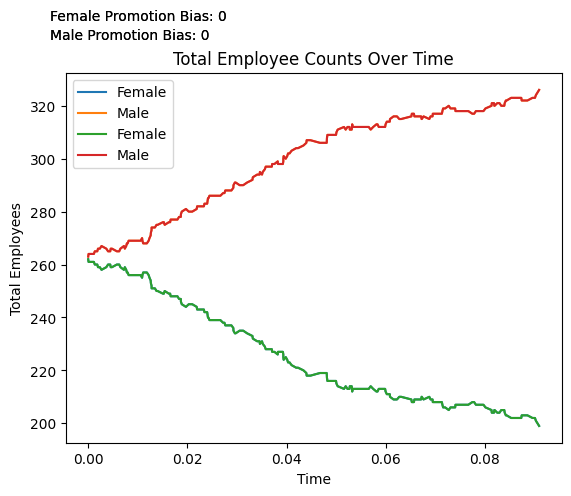

In [ ]:
# Test your code at least once
simple_params = WorkplaceParams(levels=[0,1,2,3],
                                identity=[0, 1],
                                departure_rate=[[5,5],[5,5],[5,5],[5,5]],
                                hiring_promotion_rate=[[1,5],[1,5],[1,5],[1,5]],
                                has_seniority=False,
                                has_homophily=False)

path = run_ctmc(SimpleWorkplaceModel(simple_params), SimpleWorkplaceState([[200,200],[50,50],[10,10],[2,3]]))
graph_workplace_state(path)
graph_workplace_state(path)

In [ ]:
import imageio
from celluloid import Camera
from IPython.display import Image

def create_animation(path):
    fig = plt.figure()
    camera = Camera(fig)

    for time, state in path:
        visualize_workplace_state(time, state)
        camera.snap()

    animation = camera.animate()
    animation.save('workplace.gif')
    display(Image(data=open('workplace.gif','rb').read(), format='gif'))

In [ ]:
# Example usage:
# path = run_ctmc(SimpleWorkplaceModel(WorkplaceParams([0,1,2,3], [0, 1],[[5,5],[5,5],[5,5],[5,5]], [[5,1],[5,1],[5,1],[5,1]], False, False)), SimpleWorkplaceState([[200,200],[50,50],[10,10],[2,3]]))
# create_animation(path)

## §3. Implementing a more extensible model for the project

#### ANSWER

In [ ]:
class Identity(enum.Enum):
    FEMALE = enum.auto()
    MALE = enum.auto()

indentity_to_index = {Identity.FEMALE: 0, Identity.MALE: 1}
index_to_indentity = {0:Identity.FEMALE, 1: Identity.MALE}

@dataclass(frozen=True)
class Employee:
    identity: Identity
    hiring_and_promotion_times: list[float]
    time : int # and is set to 0 initially and then +1 every time increment

    @property
    def level(self):
        return len(self.hiring_and_promotion_times) - 1

    @property
    def current_level_time(self):
        return self.time - self.hiring_and_promotion_times[-1]

    @staticmethod
    def sample_new_hire(p_female):
        i = Identity.FEMALE if RNG.random() < p_female else Identity.MALE
        return Employee(i, [0], 0)

    def promoted(self):
        return Employee(
            self.identity,
            self.hiring_and_promotion_times + [self.time],
            self.time
        )

    def time_pass_by(self):
      return Employee(
            self.identity,
            self.hiring_and_promotion_times,
            self.time +1
        )

@dataclass
class ComplexWorkplaceState:
    # each index i in the list store the ith level Employee dict
    # for each dict, key is the index of the Employee from 0 to n-1, value is the Employee
    # Stored this way make it easier to delete or add new Employee based on index
    employees: list[dict[int: Employee]]


    def to_simple_state(self):
        return SimpleWorkplaceState(
            [[sum(1 for key in employee if employee[key].identity == Identity.FEMALE),
              sum(1 for key in employee if employee[key].identity == Identity.MALE)] for employee in self.employees]
        )

    def advance_once(self):
      for employee in self.employees:
        for key in employee:
          employee[key] = employee[key].time_pass_by()

    def random_choose_departure(self, level, identity):
      # when decided level and identity, random choose one, can add factors
      employees_level = self.employees[level]
      employee_list = []
      other_list = []
      for key in employees_level:
        if employees_level[key].identity == identity:
          employee_list.append(key)
        else:
          other_list.append(key)
      if len(employee_list) == 0:
        employee_list = other_list
      random_int = RNG.integers(0, len(employee_list))
      del self.employees[level][employee_list[random_int]]
      return employee_list[random_int]

    def hire_new(self, level, index, p_female):
      self.employees[level][index] = Employee.sample_new_hire(p_female)

    def promote_senior(self, level, index, p_female):
      # add from lower level
      employees_level = self.employees[level-1]
      senior_time = -1
      senior_female_map = defaultdict(list)
      senior_male_map = defaultdict(list)
      for key in employees_level:
        current_employee_time = employees_level[key].current_level_time
        if employees_level[key].identity == Identity.FEMALE:
          senior_female_map[current_employee_time].append(key)
        else:
          senior_male_map[current_employee_time].append(key)
        senior_time = max(senior_time, current_employee_time)

      if (RNG.random() < p_female and len(senior_female_map[senior_time]) != 0) or len(senior_male_map[senior_time])== 0:
        senior_list = senior_female_map[senior_time]
      else:
        senior_list = senior_male_map[senior_time]

      random_int = RNG.integers(0, len(senior_list))
      self.employees[level][index] = self.employees[level-1][senior_list[random_int]].promoted()
      del self.employees[level-1][senior_list[random_int]]

      return senior_list[random_int]


    def promote_normal(self, level, index, p_female):
      employees_level = self.employees[level-1]
      female_list = []
      male_list = []
      for key in employees_level:
        if employees_level[key].identity == Identity.FEMALE:
          female_list.append(key)
        else:
          male_list.append(key)

      if (RNG.random() < p_female and len(female_list) != 0) or len(male_list)== 0:
        final_list = female_list
      else:
        final_list = male_list

      random_int = RNG.integers(0, len(final_list))
      self.employees[level][index] = self.employees[level-1][final_list[random_int]].promoted()
      del self.employees[level-1][final_list[random_int]]

      return final_list[random_int]

    def promote_homophily(self, level, index, p_female, has_seniority):
      employees_level = self.employees[level-1]
      female_list = []
      male_list = []
      final_list = []
      for key in employees_level:
        if employees_level[key].identity == Identity.FEMALE:
          female_list.append(key)
        else:
          male_list.append(key)

      for key in self.employees[level]:
        if self.employees[level][key].identity == Identity.FEMALE:
          prob = p_female + 0.5
        else:
          prob = p_female - 0.5

        if (RNG.random() < prob and len(female_list)!= 0) or len(male_list)== 0:
          final_list.append(female_list[RNG.integers(0, len(female_list))])
        else:
          final_list.append(male_list[RNG.integers(0, len(male_list))])

      if has_seniority:
        senior_map = defaultdict(list)
        senior_time = -1
        for key in final_list:
          current_employee_time = employees_level[key].current_level_time
          senior_map[current_employee_time].append(key)
          senior_time = max(senior_time, current_employee_time)
        final_list = senior_map[senior_time]


      random_int = RNG.integers(0, len(final_list))
      self.employees[level][index] = self.employees[level-1][final_list[random_int]].promoted()
      del self.employees[level-1][final_list[random_int]]

      return final_list[random_int]

@dataclass
class ComplexWorkplaceModel:
    params: WorkplaceParams

    def transition_rate(self, state: ComplexWorkplaceState):
        # Since the factor mentioned in Additional factors to consider
        # does not affect departure rates at all
        # this would be same as simple model
        # if needed, more factor can also be added to this
        total_rate = 0
        simple_state = state.to_simple_state()
        for level in range(len(self.params.levels)):
          for i in self.params.identity:
            total_rate += self.params.departure_rate[level][i] * simple_state.n[level][i]
        return total_rate


    def sample_next(self, state: ComplexWorkplaceState):
        new_state = ComplexWorkplaceState(copy.deepcopy(state.employees))
        new_state.advance_once()
        simple_state = state.to_simple_state()
        rand_num = RNG.random() * self.transition_rate(state)
        left_level = -1
        left_identity_index = -1
        cumulative_rate = 0
        for level in range(len(self.params.levels)):
          for i in self.params.identity:
            if left_level != -1:
              continue
            cumulative_rate += self.params.departure_rate[level][i] * simple_state.n[level][i]
            if rand_num < cumulative_rate:
              left_level = level
              left_identity_index = i
        left_identity =  index_to_indentity[left_identity_index]
        left_index = new_state.random_choose_departure(left_level,left_identity)

        # we need to fill vacancies from top level
        for i in range(left_level, -1, -1):
          if i == 0: # new hire does not change for now
            p_female = self.params.hiring_promotion_rate[i][0] / sum(self.params.hiring_promotion_rate[i])
            new_state.hire_new(i, left_index, p_female)
          else:  # Promotion from lower level
            female_promotion_weights = self.params.hiring_promotion_rate[i][0] * simple_state.n[i-1][0]
            male_promotion_weights = self.params.hiring_promotion_rate[i][1] * simple_state.n[i-1][1]
            prob_female_promotion = female_promotion_weights / (female_promotion_weights + male_promotion_weights)
            if (not self.params.has_seniority and not self.params.has_homophily):
              # promote without any seniority or homophily
              left_index = new_state.promote_normal(i, left_index, prob_female_promotion)
            elif self.params.has_homophily:
              # promote with homophily, with or without seniority
              # since the only characteristic is gender
              # start with prob_female_promotion,
              # each male employee choose a gender with prob_female_promotion - 0.5
              # each female employee choose a gender with prob_female_promotion + 0.5
              # finally form a list of number of people in current level
              # if has seniority, will choose the senior from the list
              left_index = new_state.promote_homophily(i, left_index, prob_female_promotion, self.params.has_seniority)
            else:
              # promote with seniority only
              # first choose promotion identity based on prob_female_promotion
              # then random choose from senior employee with chosen identity unless there is none
              left_index = new_state.promote_senior(i, left_index, prob_female_promotion)


        return new_state

In [ ]:
# Testing conversion to simple state
ComplexWorkplaceState([
    {i:Employee.sample_new_hire(0.5) for i in range(400)},
    {i:Employee.sample_new_hire(0.5) for i in range(100)},
    {i:Employee.sample_new_hire(0.5) for i in range(20)},
    {i:Employee.sample_new_hire(0.5) for i in range(5)}]
).to_simple_state()

SimpleWorkplaceState(n=[[192, 208], [45, 55], [10, 10], [2, 3]])

In [ ]:
params = WorkplaceParams(levels=[0,1,2,3],
                         identity=[0, 1],
                         departure_rate=[[5,5],[0,5],[5,5],[5,5]],
                         hiring_promotion_rate=[[5,5],[5,5],[5,5],[5,5]],
                         has_seniority=False,
                         has_homophily=True)

complex_model = ComplexWorkplaceModel(params)
complex_state_init = ComplexWorkplaceState([
    {i:Employee.sample_new_hire(0.5) for i in range(400)},
    {i:Employee.sample_new_hire(0.5) for i in range(100)},
    {i:Employee.sample_new_hire(0.5) for i in range(20)},
    {i:Employee.sample_new_hire(0.5) for i in range(5)}]
)
# complex_path = run_ctmc(complex_model, complex_state_init)
# graph_workplace_state(complex_path, level_by_level=True, is_complex=True)
# graph_workplace_state(complex_path)

# simulation_0 = [(t, s.to_simple_state()) for (t, s) in complex_path]

In [ ]:
level_0 = {i : Employee(Identity.FEMALE, [0], 0) for i in range(200)}
level_0.update({i : Employee(Identity.MALE, [0], 0) for i in range(201,401)})

level_1 = {i : Employee(Identity.FEMALE, [0], 0) for i in range(50)}
level_1.update({i : Employee(Identity.MALE, [0], 0) for i in range(51,101)})

level_2 = {i : Employee(Identity.FEMALE, [0], 0) for i in range(10)}
level_2.update({i : Employee(Identity.MALE, [0], 0) for i in range(11,21)})

level_3 = {i : Employee(Identity.FEMALE, [0], 0) for i in range(3)}
level_3.update({i : Employee(Identity.MALE, [0], 0) for i in range(4,6)})

female_promotion_bias: 0.4, male_promotion_bias: 0.6


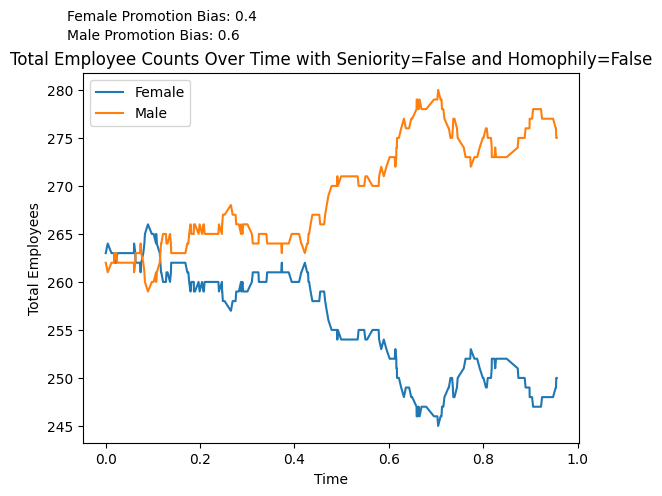

female_promotion_bias: 0.45, male_promotion_bias: 0.55


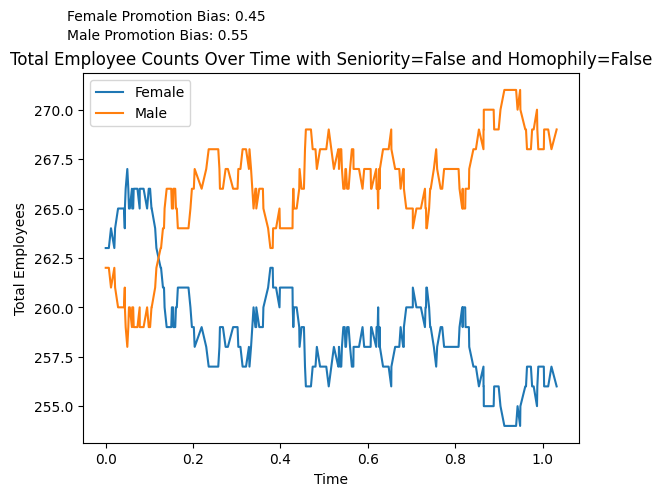

female_promotion_bias: 0.5, male_promotion_bias: 0.5


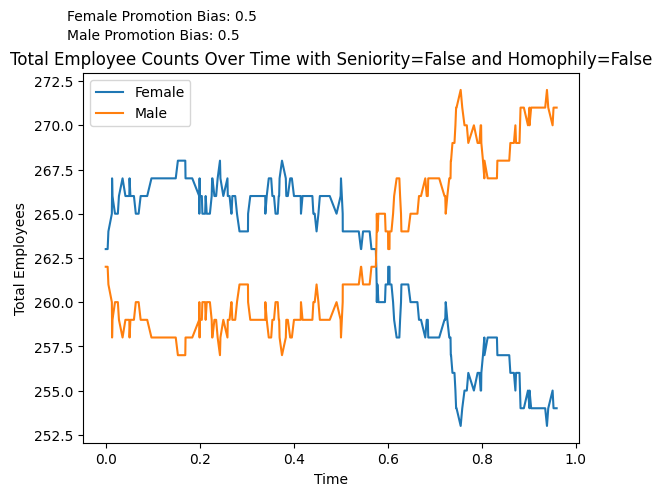

female_promotion_bias: 0.4, male_promotion_bias: 0.6


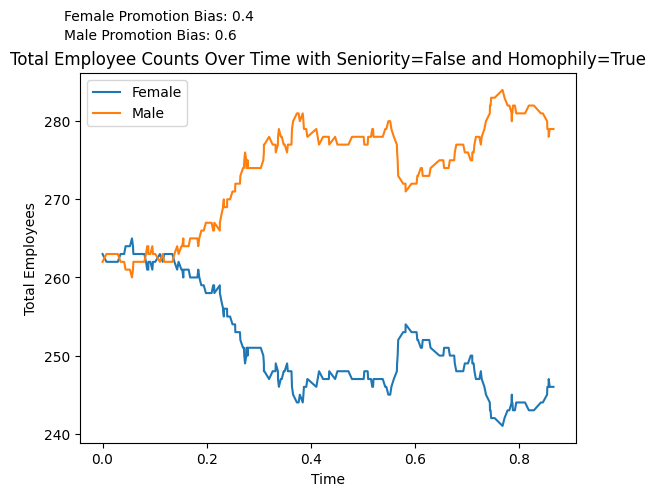

female_promotion_bias: 0.45, male_promotion_bias: 0.55


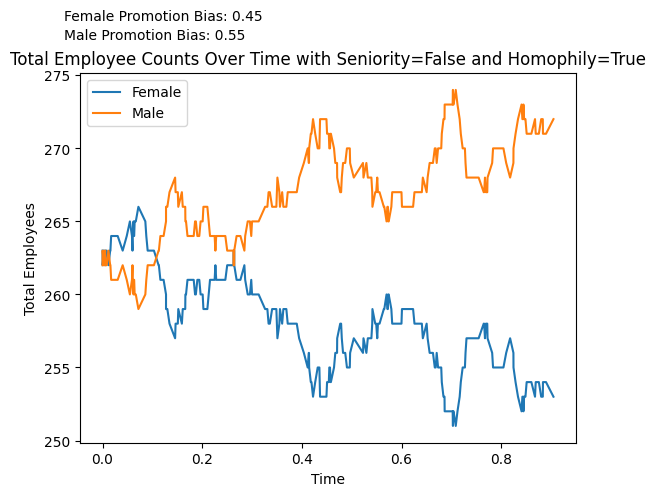

female_promotion_bias: 0.5, male_promotion_bias: 0.5


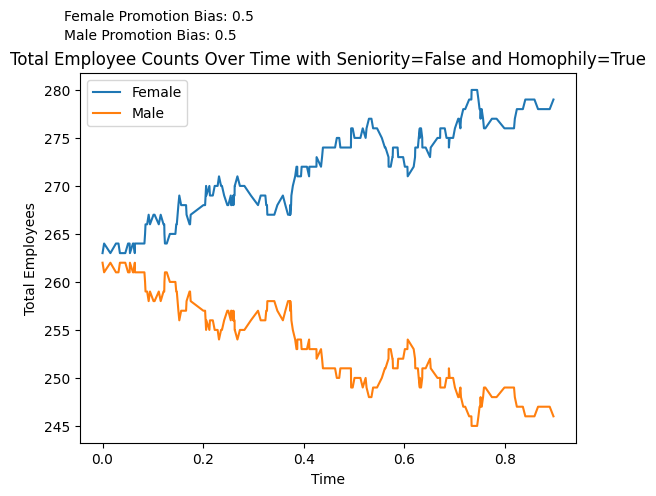

female_promotion_bias: 0.4, male_promotion_bias: 0.6


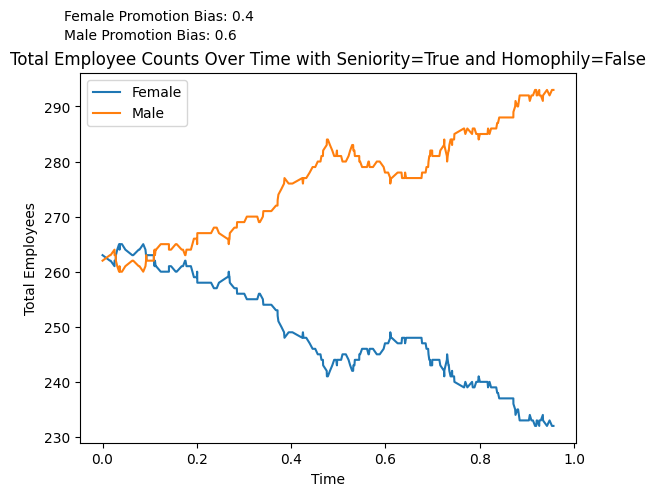

female_promotion_bias: 0.45, male_promotion_bias: 0.55


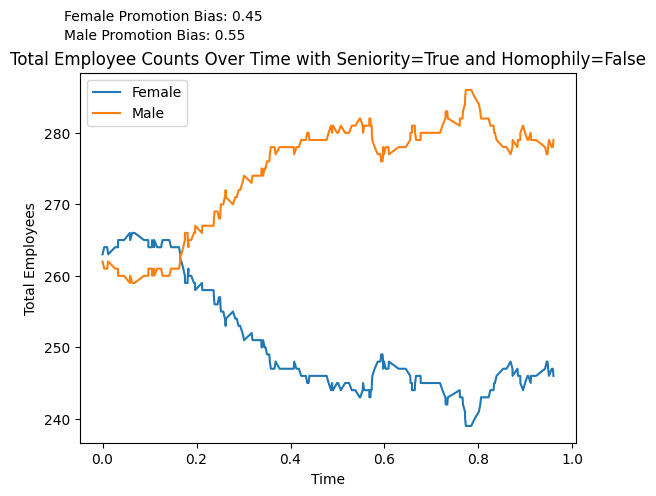

female_promotion_bias: 0.5, male_promotion_bias: 0.5


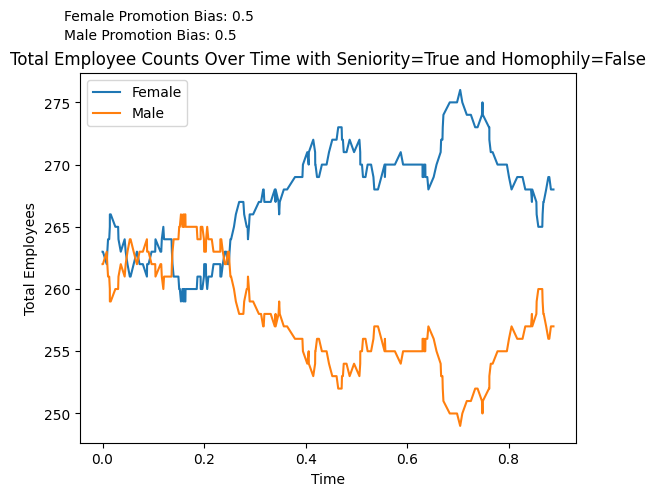

female_promotion_bias: 0.4, male_promotion_bias: 0.6


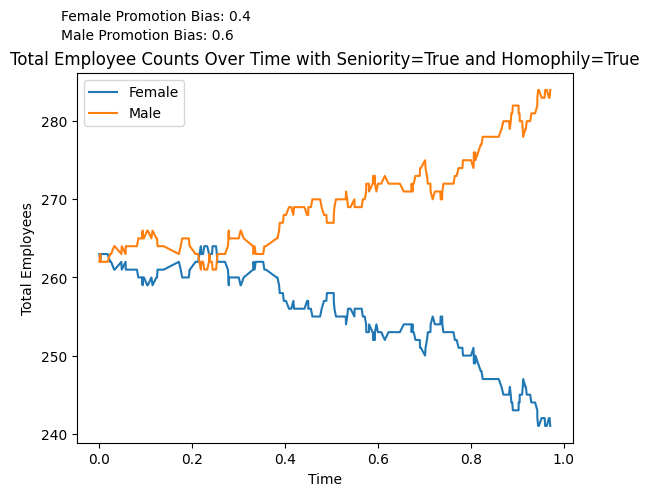

female_promotion_bias: 0.45, male_promotion_bias: 0.55


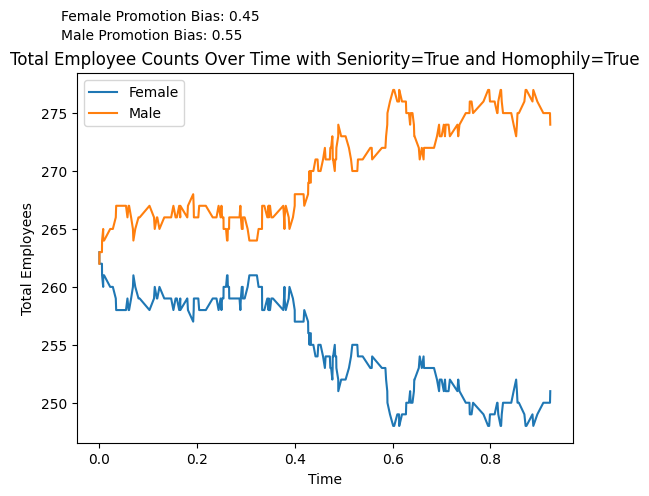

female_promotion_bias: 0.5, male_promotion_bias: 0.5


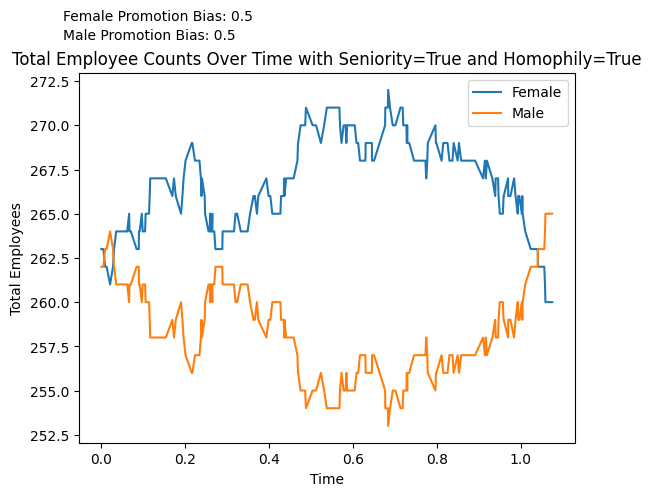

In [ ]:
# prob_hire_female = 0.5
complex_state_init = ComplexWorkplaceState([level_0,
                                            level_1,
                                            level_2,
                                            level_3])
for s,h in [[False,False],[False,True],[True,False],[True,True]]:
  for j in range(3):
    female_promotion_bias = 0.4 + 0.05*(j) #0 1
    male_promotion_bias = 1 - female_promotion_bias
    params = WorkplaceParams(levels=[0,1,2,3],
                          identity=[0, 1],
                          departure_rate=[[0.5,0.5],[0.5,0.5],[0.5,0.5],[0.5,0.5]],
                          hiring_promotion_rate=[[female_promotion_bias,male_promotion_bias],[female_promotion_bias,male_promotion_bias],[female_promotion_bias,male_promotion_bias],[female_promotion_bias,male_promotion_bias]],
                          has_seniority=s,
                          has_homophily=h)

    complex_model = ComplexWorkplaceModel(params)

    # complex_state_init = ComplexWorkplaceState([
    #     {i:Employee.sample_new_hire(prob_hire_female) for i in range(400)},
    #     {i:Employee.sample_new_hire(prob_hire_female) for i in range(100)},
    #     {i:Employee.sample_new_hire(prob_hire_female) for i in range(20)},
    #     {i:Employee.sample_new_hire(prob_hire_female) for i in range(5)}]
    # )

    complex_path = run_ctmc(complex_model, complex_state_init)
    # graph_workplace_state(complex_path, level_by_level=True, is_complex=True)

    metadata = {
        "is_complex" : True,
        "level_by_level" : False,
        "female_promotion_bias": female_promotion_bias,
        "male_promotion_bias": male_promotion_bias
    }
    graph_workplace_state(complex_path, metadata=metadata)
    print(f"female_promotion_bias: {female_promotion_bias}, male_promotion_bias: {male_promotion_bias}")
    plt.title(f'Total Employee Counts Over Time with Seniority={s} and Homophily={h}')
    plt.plot(label=f"Female promotion rate: {female_promotion_bias}")
    plt.show()

In [ ]:
# path = run_ctmc(complex_model, complex_state_init)
# graph_workplace_state(path, level_by_level=True, is_complex=True
# create_animation(complex_path)

In [ ]:
import numpy as np

# Define ranges for your parameters
departure_rates = np.linspace(0.1, 1.0, 10)  # 10 values between 0.1 and 1.0
hiring_rates = np.linspace(0.5, 1.5, 10)      # 10 values between 0.5 and 1.5

# Store results
results = []

# Loop through parameter variations
for departure_rate in departure_rates:
    for hiring_rate in hiring_rates:
        # Create WorkplaceParams with varied parameters
        params = WorkplaceParams(
            levels=[0, 1, 2, 3],
            identity=[0, 1],
            departure_rate=[[departure_rate, departure_rate]] * 4,  # Same for all levels
            hiring_promotion_rate=[[hiring_rate, hiring_rate]] * 4,  # Same for all levels
            has_seniority=False,
            has_homophily=False
        )

        complex_model = ComplexWorkplaceModel(params)
        # Run your simulation
        path = run_ctmc(complex_model, complex_state_init)
        state = path[-1][1]
        # print(path[-1][1])
        # Calculate output metrics (e.g., total employees at the end)
        total_employees = sum(state.to_simple_state().n[level][0] + state.to_simple_state().n[level][1]
                              for level in range(len(state.to_simple_state().n))
                              for time, state in path[-1:])  # Get last state

        # Store results
        results.append((departure_rate, hiring_rate, total_employees))

# Analyze the results (e.g., plot them)
# ...

In [ ]:
for r in results:
  print(r)

(0.1, 0.5, 525)
(0.1, 0.6111111111111112, 525)
(0.1, 0.7222222222222222, 525)
(0.1, 0.8333333333333333, 525)
(0.1, 0.9444444444444444, 525)
(0.1, 1.0555555555555556, 525)
(0.1, 1.1666666666666665, 525)
(0.1, 1.2777777777777777, 525)
(0.1, 1.3888888888888888, 525)
(0.1, 1.5, 525)
(0.2, 0.5, 525)
(0.2, 0.6111111111111112, 525)
(0.2, 0.7222222222222222, 525)
(0.2, 0.8333333333333333, 525)
(0.2, 0.9444444444444444, 525)
(0.2, 1.0555555555555556, 525)
(0.2, 1.1666666666666665, 525)
(0.2, 1.2777777777777777, 525)
(0.2, 1.3888888888888888, 525)
(0.2, 1.5, 525)
(0.30000000000000004, 0.5, 525)
(0.30000000000000004, 0.6111111111111112, 525)
(0.30000000000000004, 0.7222222222222222, 525)
(0.30000000000000004, 0.8333333333333333, 525)
(0.30000000000000004, 0.9444444444444444, 525)
(0.30000000000000004, 1.0555555555555556, 525)
(0.30000000000000004, 1.1666666666666665, 525)
(0.30000000000000004, 1.2777777777777777, 525)
(0.30000000000000004, 1.3888888888888888, 525)
(0.30000000000000004, 1.5, 525)


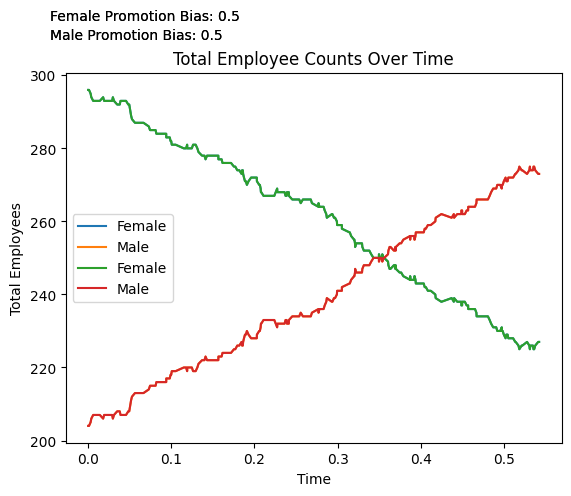

In [ ]:
params = WorkplaceParams(levels=[0,1],
                         identity=[0, 1],
                         departure_rate=[[0,0],[5,5]],
                         hiring_promotion_rate=[[5,5],[5,5]],
                         has_seniority=True,
                         has_homophily=True)

complex_model = ComplexWorkplaceModel(params)
complex_state_init = ComplexWorkplaceState([
    {i:Employee.sample_new_hire(0.5) for i in range(400)},
    {i:Employee.sample_new_hire(0.8) for i in range(100)},]
)
complex_path = run_ctmc(complex_model, complex_state_init)

metadata = {
        "is_complex" : True,
        "level_by_level" : False,
        "female_promotion_bias": 0.5,
        "male_promotion_bias": 0.5
    }

graph_workplace_state(complex_path,metadata)
graph_workplace_state(complex_path,metadata)